<a href="https://colab.research.google.com/github/abstractguy/crypto_bot/blob/master/crypto_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cryptocurrency trading bot.

Hardcoded parameters.

In [0]:
symbol = 'ETH-BTC'
period = '60m'
interval = '1m'

Installs.

In [2]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.54)


Library imports.

In [0]:
%matplotlib inline

import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

Function definitions.

In [0]:
def fill_NANs(dataframe):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)
    dataframe.iloc[0] = dataframe.iloc[1]
    return dataframe.fillna(axis='index', method='pad')

def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['Open', 'High', 'Low', 'Close'])
    heikin_ashi_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['Open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['High'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['High']).max(axis=1)
    heikin_ashi_df['Low'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['Low']).min(axis=1)

    return heikin_ashi_df

Download cryptocurrency symbol data.

In [5]:
dataset_downloaded = yf.download(tickers=[symbol], 
                                 period=period, 
                                 interval=interval, 
                                 group_by='ticker', 
                                 auto_adjust=True, 
                                 prepost=True)

dataset_downloaded = fill_NANs(dataset_downloaded)
dataset_downloaded

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2020-03-16 04:51:00+00:00,0.023160,0.023160,0.023160,0.023160,944.0
2020-03-16 04:52:00+00:00,0.023160,0.023160,0.023160,0.023160,944.0
2020-03-16 04:53:00+00:00,0.023181,0.023181,0.023181,0.023181,2334.0
2020-03-16 04:54:00+00:00,0.023187,0.023187,0.023187,0.023187,873.0
2020-03-16 04:55:00+00:00,0.023175,0.023175,0.023175,0.023175,0.0
2020-03-16 04:56:00+00:00,0.023145,0.023145,0.023145,0.023145,0.0
2020-03-16 04:57:00+00:00,0.023169,0.023169,0.023169,0.023169,2814.0
2020-03-16 04:58:00+00:00,0.023136,0.023136,0.023136,0.023136,0.0
2020-03-16 04:59:00+00:00,0.023154,0.023154,0.023154,0.023154,0.0


Download testing area -->

<-- End of download testing area.

*** To avoid downloading multiple times, restart here. ***

In [6]:
dataset = dataset_downloaded.copy()
dataset

,Open,High,Low,Close,Volume
Datetime,,,,,
2020-03-16 04:51:00+00:00,0.023160,0.023160,0.023160,0.023160,944.0
2020-03-16 04:52:00+00:00,0.023160,0.023160,0.023160,0.023160,944.0
2020-03-16 04:53:00+00:00,0.023181,0.023181,0.023181,0.023181,2334.0
2020-03-16 04:54:00+00:00,0.023187,0.023187,0.023187,0.023187,873.0
2020-03-16 04:55:00+00:00,0.023175,0.023175,0.023175,0.023175,0.0
2020-03-16 04:56:00+00:00,0.023145,0.023145,0.023145,0.023145,0.0
2020-03-16 04:57:00+00:00,0.023169,0.023169,0.023169,0.023169,2814.0
2020-03-16 04:58:00+00:00,0.023136,0.023136,0.023136,0.023136,0.0
2020-03-16 04:59:00+00:00,0.023154,0.023154,0.023154,0.023154,0.0


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



,Open,High,Low,Close
2020-03-16 04:51:00,0.0231605,0.023160,0.023160,0.023160
2020-03-16 04:52:00,0.0231605,0.023160,0.023160,0.023160
2020-03-16 04:53:00,0.0231605,0.023181,0.023160,0.023181
2020-03-16 04:54:00,0.0231707,0.023187,0.023171,0.023187
2020-03-16 04:55:00,0.0231786,0.023179,0.023175,0.023175
2020-03-16 04:56:00,0.0231768,0.023177,0.023145,0.023145
2020-03-16 04:57:00,0.0231607,0.023169,0.023161,0.023169
2020-03-16 04:58:00,0.0231647,0.023165,0.023136,0.023136
2020-03-16 04:59:00,0.0231502,0.023154,0.023150,0.023154
2020-03-16 05:00:00,0.0231522,0.023201,0.023152,0.023201


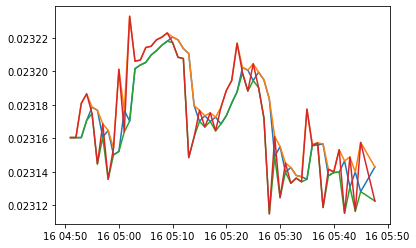

In [7]:
dataset = dataset.tz_localize(tz=None, ambiguous='infer')
heikin_ashi_dataset = heikin_ashi(dataset)
plt.plot(heikin_ashi_dataset)
heikin_ashi_dataset

In [8]:
fig = go.Figure(data=[go.Candlestick(x=heikin_ashi_dataset.index.to_series(), 
                                     open=heikin_ashi_dataset['Open'], 
                                     high=heikin_ashi_dataset['High'], 
                                     low=heikin_ashi_dataset['Low'], 
                                     close=heikin_ashi_dataset['Close'])])

fig.show()